In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [35]:
df = pd.read_csv("data/cleaned_data.csv")

In [36]:
df.head()

,gdp,population,total_generation,co2
0,4.156140e+12,195653775.0,310.420034,3399.547
1,4.428300e+12,198265397.0,310.420034,3571.421
2,4.538980e+12,200699913.0,310.420034,3705.461
3,4.754930e+12,203011021.0,310.420034,3840.919
4,4.903770e+12,205300032.0,310.420034,4035.145


**Determining the differencing needed to make CO_2 (outcome) stationary**

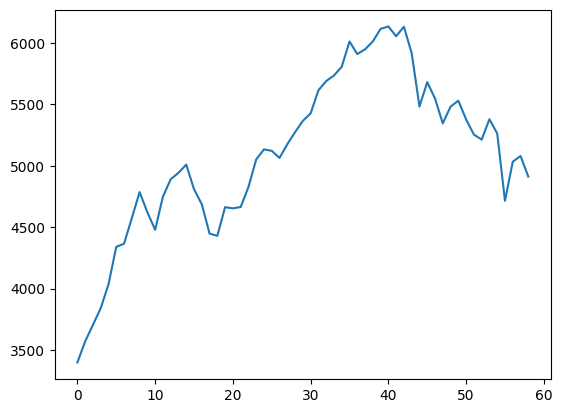

In [37]:
df["co2"].plot()
plt.show()

The initial CO_2 is not stationary. This is expected as the CO_2 usage should have increased over the last 60 years.

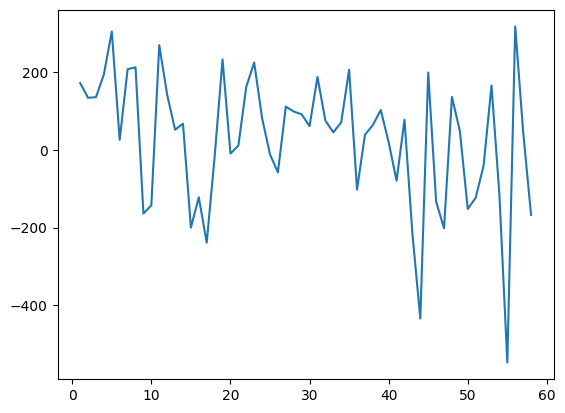

In [38]:
df["co2"].diff().plot()
plt.show()

This seems to be stationary, as the mean is constant near 0 and the variance appears to be homoscedastic. We will check with ADF test.

In [39]:
y = df["co2"].diff().dropna()
res = adfuller(y, maxlag=None, regression='c')
stat, pval, usedlag, nobs, crit, icbest = res

print(f"ADF statistic: {res[0]:.3f}")
print(f"p-value: {res[1]:.4f}")

ADF statistic: -3.148
p-value: 0.0232


Since p-value < 0.05, the differenced series is stationary, so d = 1

**Removing multicollinearity in the features**

In [41]:
X = df[["gdp", "population", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features        VIF
0               gdp  33.740579
1        population  12.295812
2  total_generation   4.509105


There is excessive multicollinearity between gdp and population.

In [50]:
X = df[["population", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features         VIF
0        population  146.493809
1  total_generation  146.493809


In [42]:
X = df[["gdp", "total_generation"]]
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

           features        VIF
0               gdp  10.972917
1  total_generation  10.972917


However by removing either, the remaining feature becomes significantly correlated with total_generation as well. We will keep total_generation only to avoid multicollinearity.

In [44]:
df_final = df[["total_generation", "co2"]]

**Determining p and q for the ARIMAX Model**

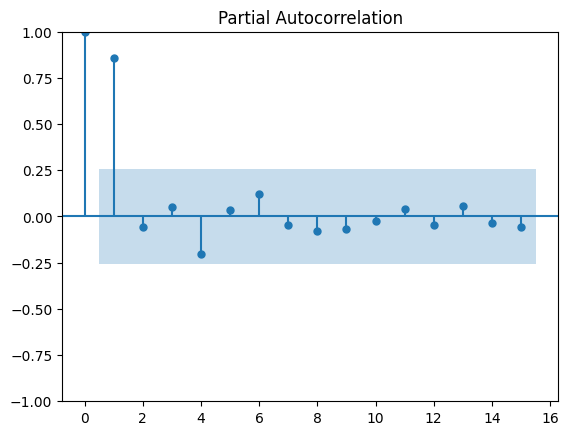

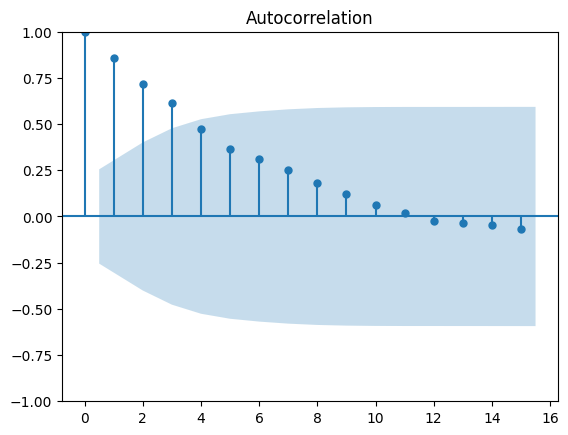

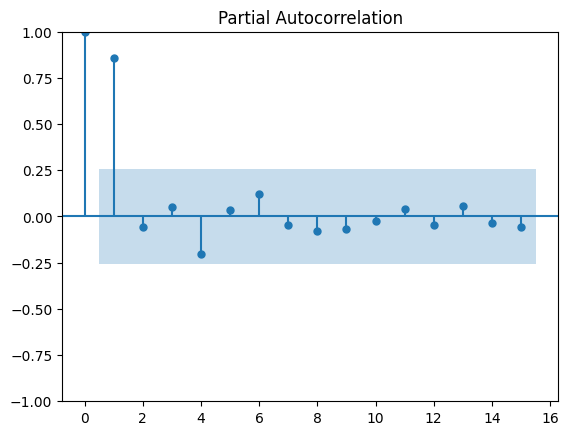

In [49]:
y = df_final['co2']
X = df_final[["total_generation"]]

res = sm.OLS(y, sm.add_constant(X)).fit().resid

sm.graphics.tsa.plot_acf(res, lags=15)
sm.graphics.tsa.plot_pacf(res, lags=15)

As shown in the plots, PACF cuts off at lag = 2 and ACF slowly trails off. That means p = ... and q = 0

**Fitting the model**

In [54]:
model = SARIMAX(y, exog = X, order = (1, 1, 0))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -378.442
Date:                Thu, 31 Jul 2025   AIC                            764.884
Time:                        17:25:34   BIC                            773.125
Sample:                             0   HQIC                           768.094
                                 - 59                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
population        9.343e-06   1.09e-05      0.861      0.389   -1.19e-05    3.06e-05
total_generation    -2.1724      1.294     -1.679      0.093      -4.709       0.364
ar.L1                0.0809 

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#res.plot_diagnostics(figsize=(10,8));  # ACF of residuals, QQ plot, etc.

# Ljung–Box test: large p-values -> no residual autocorrelation
lb = acorr_ljungbox(res.resid.dropna(), lags=[10, 20], return_df=True)
print(lb)

     lb_stat  lb_pvalue
10  4.123980   0.941581
20  8.475145   0.988228
